In [1]:
from fastmcp import Client

from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Union
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

In [2]:
client = Client("http://localhost:8001/mcp")

async with client:
    tools = await client.list_tools()

In [6]:
tools

[Tool(name='get_formatted_context', title=None, description='Get the top k context, each representing an job posting for a given query.\n\nArgs:\n    query: The query to get the top k context for\n    top_k: The number of context chunks to retrieve, works best with 5 or more\n\nReturns:\n    A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.', inputSchema={'properties': {'query': {'title': 'Query', 'type': 'string'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer'}}, 'required': ['query'], 'type': 'object'}, outputSchema={'additionalProperties': True, 'type': 'object'}, annotations=None, meta={'_fastmcp': {'tags': []}})]

In [7]:
print(tools[0].name)
print(tools[0].description)
print(tools[0].inputSchema)

get_formatted_context
Get the top k context, each representing an job posting for a given query.

Args:
    query: The query to get the top k context for
    top_k: The number of context chunks to retrieve, works best with 5 or more

Returns:
    A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.
{'properties': {'query': {'title': 'Query', 'type': 'string'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer'}}, 'required': ['query'], 'type': 'object'}


In [8]:
client = Client("http://localhost:8002/mcp")

async with client:
    # List available resources
    tools = await client.list_tools()

In [9]:
print(tools[0].name)
print(tools[0].description)
print(tools[0].inputSchema)

get_prediction
Classifies if a given job posting is real or fake.
Uses the top retrieved job posting from get_formatted_context as input
and return the classification result.

Args:
    text: Input string of the job posting

Returns:
    A dictionary of the classification label and prediction probability score.
{'properties': {'text': {'title': 'Text', 'type': 'string'}}, 'required': ['text'], 'type': 'object'}


In [4]:
client = Client("http://localhost:8003/mcp")

async with client:
    # List available resources
    tools = await client.list_tools()

print(tools[0].name)
print(tools[0].description)
print(tools[0].inputSchema)

get_formatted_entities
Get the top k context, each representing an job posting for a given query.

Args:
    query: The query to get the top k context for
    top_k: The number of context chunks to retrieve, works best with 5 or more

Returns:
    A string of the top k context chunks with IDs prepending each chunk follow by entities extracted using spaCy.
{'properties': {'query': {'title': 'Query', 'type': 'string'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer'}}, 'required': ['query'], 'type': 'object'}


# Utils function - Extract tool definitions from all available tools in MCP serves

In [2]:
def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params

In [3]:
async def get_tool_descriptions_from_mcp_servers(mcp_servers: list[str]) -> list[dict]:

    tool_descriptions = []

    for server in mcp_servers:

        client = Client(server)

        async with client:

            tools = await client.list_tools()

            for tool in tools:
                
                result = {
                    "name": "",
                    "description": "",
                    "parameters": {"type": "object", "properties": {}},
                    "required": [],
                    "returns": {"type": "str", "description": ""},
                    "server": server
                }

                result["name"] = tool.name
                result["required"] = tool.inputSchema.get("required", [])

                ## Get Description

                description = tool.description.split("\n\n")[0]
                result["description"] = description


                ## Get Returns

                returns = tool.description.split("Returns:")[1].strip()
                result["returns"]["description"] = returns


                ## Get parameters

                property_descriptions = parse_docstring_params(tool.description)
                properties = tool.inputSchema.get("properties", {})
                for key, value in properties.items():
                    properties[key]["description"] = property_descriptions.get(key, "")

                result["parameters"]["properties"] = properties

                tool_descriptions.append(result)

    return tool_descriptions

In [4]:
mcp_servers = ["http://localhost:8001/mcp", 
               "http://localhost:8002/mcp",
               "http://localhost:8003/mcp"
               ]

In [5]:
tool_descriptions = await get_tool_descriptions_from_mcp_servers(mcp_servers)
tool_descriptions

[{'name': 'get_formatted_context',
  'description': 'Get the top k context, each representing an job posting for a given query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the top k context for'},
    'top_k': {'default': 5,
     'title': 'Top K',
     'type': 'integer',
     'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
  'required': ['query'],
  'returns': {'type': 'str',
   'description': 'A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.'},
  'server': 'http://localhost:8001/mcp'},
 {'name': 'get_prediction',
  'description': 'Classifies if a given job posting is real or fake.\nUses the top result from get_formatted_context as input\nand return the classification result.',
  'parameters': {'type': 'object',
   'properties': {'text': {'title': 'Text',
     'type': 'string

# Agent integration to MCP Servers

In [6]:
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

In [7]:
# Pydantic Models

class ToolCall(BaseModel):
    name: str
    arguments: dict
    server: str

# from typing import Optional

# class ToolCall(BaseModel):
#     name: str
#     arguments: dict = Field(alias="parameters")
#     server: Optional[str] = None


class RAGUsedContext(BaseModel):
    id: int
    description: str

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context_ids: List[RAGUsedContext]

class QAAgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context_ids: List[RAGUsedContext]

class ClassifierAgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)


class Delegation(BaseModel):
    agent: str
    task: str = Field(default="")

class CoordinatorAgentResponse(BaseModel):
    next_agent: str
    plan: list[Delegation]
    final_answer: bool = Field(default=False)
    answer: str


class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    answer: str = ""
    iteration: int = Field(default=0)
    classifier_iteration: int = Field(default=0)
    coordinator_iteration: int = Field(default=0)
    job_posting_qa_final_answer: bool = Field(default=False)
    classifier_final_answer: bool = Field(default=False)
    coordinator_final_answer: bool = Field(default=False)
    qa_available_tools: List[Dict[str, Any]] = []
    classifier_available_tools: List[Dict[str, Any]] = []
    qa_tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    classifier_tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    retrieved_context_ids: List[RAGUsedContext] = []
    # NEW fields for classifier integration
    # retrieved_job_posting: Optional[str] = ""            # stores the retrieved job posting text
    classification_result: str = ""  # store fraud classification result
    user_intent: str = ""
    plan: list[Delegation] = Field(default_factory=list)
    next_agent: str = ""

# QA Agent Node

In [8]:
# # Example: you need a dict like this somewhere accessible
# tool_name_to_server = {
#     "get_prediction": "http://localhost:8002/mcp",
#     "get_formatted_context": "http://localhost:8001/mcp",
#     # add all your tools here
# }

In [9]:
@traceable(
    name="job_posting_qa_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def job_posting_qa_agent_node(state: State) -> dict:

   prompt_template =  """
You are part of a Analyst Assistant. The user is a Fraud Analyst and your job is to answer questions about job postings.

You may be asked to provide a summary of the job postings.

User may provide either the full job posting text, job title, or a job ID (job_id). 

If a job ID is provided, retrieve the corresponding job posting details before analysis.

You will be given a question and a list of tools you can use to answer that question.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

After the tools are used you will get the outputs from the tools.

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specifically provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

If you set final_answer to True, you should not use any tools.

Instructions:
   - Carefully analyze the provided job details and user input above.
   - You may be asked to extract entities from job postings by using `get_entities` tool.
   - Explain your analysis using retrieved information.
   - If the user's request requires using a tool, set tool_calls with the appropriate function name and parameters.
   - If you have all the information needed to provide a complete answer, set final_answer to True.
"""

   template = Template(prompt_template)

   prompt = template.render(
      available_tools=state.qa_available_tools
   )
   print("[DEBUG] QA Agent State: ", state.model_dump_json)
   messages = state.messages

   conversation = []   # Previous messages + tool messages

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   print("[DEBUG] QA Messages so far: ", messages)

   client = instructor.from_openai(OpenAI())

   # response, raw_response = client.chat.completions.create_with_completion(
   #    model="gpt-4.1-mini",
   #    response_model=AgentResponse,
   #    messages=[{"role": "system", "content": prompt}, *conversation],
   #    temperature=0.5,
   # )

   from instructor.exceptions import InstructorRetryException

   try:
      response, raw_response = client.chat.completions.create_with_completion(
         model="gpt-4.1",
         response_model=QAAgentResponse,
         messages=[{"role": "system", "content": prompt}, *conversation],
         temperature=0.,
      )
   except InstructorRetryException as ire:
      print("[QA Agent] Raw LLM output that caused error:", ire.last_completion)
      raise  # or handle as needed


   # If using the sync API:
   # raw = client.chat.completions.create(
   #    model="gpt-4.1-mini",
   #    messages=[{"role": "system", "content": prompt}, *conversation],
   #    temperature=0.5,
   #    # Don't include response_model here if you want the raw output
   # )
   # print("[DEBUG] Raw response:", json.dumps(raw, indent=2))
      

   # current_run = get_current_run_tree()
   # if current_run:
   #    current_run.metadata["usage_metadata"] = {
   #       "input_tokens": raw_response.usage.prompt_tokens,
   #       "output_tokens": raw_response.usage.completion_tokens,
   #       "total_tokens": raw_response.usage.total_tokens,
   #    }
   #    trace_id = str(getattr(current_run, "trace_id", current_run.id))

# Patch missing 'server' field in each tool_call by matching known tools list
   for tool_call in response.tool_calls:
      if not getattr(tool_call, "server", None):
         matched_tool = next((t for t in state.qa_available_tools if t["name"] == tool_call.name), None)
         if matched_tool:
               tool_call.server = matched_tool["server"]

   if response.final_answer:
      ai_message = AIMessage(
         content=response.answer,
      )
   elif response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )
   # Prepare tool calls for AIMessage

   print("[DEBUG] QA Agent tool_calls so far:",  response.tool_calls)

   return {
      "messages": [ai_message],
      "qa_tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
      "job_posting_qa_final_answer": response.final_answer,
      "retrieved_context_ids": response.retrieved_context_ids,
      # "trace_id": trace_id
   }

# Classifier Agent

In [106]:
# class ClassifierAgentResponse(BaseModel):
#     user_intent: str
#     answer: str 


In [ ]:
@traceable(
    name="classifier_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def classifier_agent_node(state: State) -> dict:

   prompt_template =  """
You are part of a Analyst Assistant that can classify whether a job posting is real or fake.

User may provide either the full job posting text, job title, or a job ID (job_id). 

You will be a conversation history and a list of tools you can use to answer that question.

You are only allowed to use the following tools:
- `get_formatted_context`
- `get_prediction`

<Available tools>
{{ available_tools | tojson }}
</Available tools>
If a job ID or job title is provided, retrieve the corresponding job posting details using `get_formatted_context` tool and extract top result before classification.

After the tools are used you will get the outputs from the tools.

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specifically provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

If you set final_answer to True, you should not use any tools.

Instructions:
   - Carefully analyze the provided job details and user input above.
   - Use up-to-date information about job scams, legitimate job ad characteristics, and known fraud patterns.
   - Provide a clear verdict: "Likely Real", "Likely Fraudulent", or "Uncertain".
   - Explain your reasoning with specific evidence from the posting, user input, and retrieved information.
   - List any red flags or positive signs you identified.
   - Offer actionable advice to the user.
   - If the user's request requires using a tool, set tool_calls with the appropriate function name and parameters.
   - If you have all the information needed to provide a complete answer, set final_answer to True.
"""

   template = Template(prompt_template)

   prompt = template.render(
      available_tools=state.classifier_available_tools
   )
   print("[DEBUG] Agent State: ", state.model_dump_json)
   messages = state.messages

   conversation = []   # Previous messages + tool messages

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   print("[DEBUG] Messages so far from Classifier Agent: ", messages)

   client = instructor.from_openai(OpenAI())

   # response, raw_response = client.chat.completions.create_with_completion(
   #    model="gpt-4.1-mini",
   #    response_model=AgentResponse,
   #    messages=[{"role": "system", "content": prompt}, *conversation],
   #    temperature=0.5,
   # )

   from instructor.exceptions import InstructorRetryException

   try:
      response, raw_response = client.chat.completions.create_with_completion(
         model="gpt-4.1-mini",
         response_model=ClassifierAgentResponse,
         messages=[{"role": "system", "content": prompt}, *conversation],
         temperature=0.5,
      )
   except InstructorRetryException as ire:
      print("[CLASSIFIER] Raw LLM output that caused error:", ire.last_completion)
      raise  # or handle as needed

   print("[DEBUG] Raw response Classifier: ", raw_response)

   # If using the sync API:
   # raw = client.chat.completions.create(
   #    model="gpt-4.1-mini",
   #    messages=[{"role": "system", "content": prompt}, *conversation],
   #    temperature=0.5,
   #    # Don't include response_model here if you want the raw output
   # )
   # print("[DEBUG] Raw response:", json.dumps(raw, indent=2))
      

   # current_run = get_current_run_tree()
   # if current_run:
   #    current_run.metadata["usage_metadata"] = {
   #       "input_tokens": raw_response.usage.prompt_tokens,
   #       "output_tokens": raw_response.usage.completion_tokens,
   #       "total_tokens": raw_response.usage.total_tokens,
   #    }
   #    trace_id = str(getattr(current_run, "trace_id", current_run.id))

# Patch missing 'server' field in each tool_call by matching known tools list
   for tool_call in response.tool_calls:
      if not getattr(tool_call, "server", None):
         matched_tool = next((t for t in state.classifier_available_tools if t["name"] == tool_call.name), None)
         if matched_tool:
               tool_call.server = matched_tool["server"]

   if response.final_answer:
      ai_message = AIMessage(
         content=response.answer,
      )
   elif response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )
   # Prepare tool calls for AIMessage

   print("[DEBUG] tool_calls so far:",  response.tool_calls)

   return {
      "messages": [ai_message],
      "classifier_tool_calls": response.tool_calls,
      "classifier_iteration": state.classifier_iteration + 1,
      "answer": response.answer,
      "classifier_final_answer": response.final_answer,
      # "retrieved_context_ids": response.retrieved_context_ids,
      # "trace_id": trace_id
   }

In [11]:
### User Intent Router Node
from instructor.exceptions import InstructorRetryException

@traceable(
    name="coordinator_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1"}
)
def coordinator_agent_node(state: State) -> dict:

   prompt_template =  """You are a Coordinator Agent as part of a fraud analyst assistant.

Your role is to create plans for solving user queries and delegate the tasks accordingly.
You will be given a conversation history, your task is to create a plan for solving the user's query.
After the plan is created, you should output the next agent to invoke and the task to be performed by that agent.
Once an agent finishes its task, you will be handed the control back, you should then review the conversation history and revise the plan.
If there is a sequence of tasks to be performed by a single agent, you should combine them into a single task.

The possible agents are:

- job_posting_qa_agent: The user is asking a question about a job posting. This can be a question about its specifications, descriptions, text entities etc.
- classifier_agent: The user is asking to classifiy job postings on whether the posting is real or not.

CRITICAL RULES:
- If next_agent is "", final_answer MUST be false
(You cannot delegate the task to an agent and return to the user in the same response)
- If final_answer is true, next_agent MUST be ""
(You must wait for agent results before returning to user)
- If you need to call other agents before answering, set:
next_agent="...", final_answer=false
- After receiving agent results, you can then set:
next_agent="", final_answer=true

Additional instructions:

- Write the plan to the plan field.
- Write the next agent to invoke to the next_agent field.
- Once you have all the information needed to answer the user's query, you should set the final_answer field to True and output the answer to the user's query.
- The final answer to the user query should be a comprehensive answer that explains the actions that were performed to answer the query.
- Never set final_answer to true if the plan is not complete.
- You should output the next_agent field as well as the plan field.
"""

   template = Template(prompt_template)

   prompt = template.render()
   print("[DEBUG] Coordinator Agent State: ", state.model_dump_json)
   messages = state.messages

   conversation = []   # Previous messages + tool messages

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   print("[DEBUG] Messages so far Coordinator Agent: ", messages)

   client = instructor.from_openai(OpenAI())

   # response, raw_response = client.chat.completions.create_with_completion(
   #    model="gpt-4.1-mini",
   #    response_model=AgentResponse,
   #    messages=[{"role": "system", "content": prompt}, *conversation],
   #    temperature=0.5,
   # )

   
   try:
      response, raw_response = client.chat.completions.create_with_completion(
         model="gpt-4.1",
         response_model=CoordinatorAgentResponse,
         messages=[{"role": "system", "content": prompt}, *conversation],
         temperature=0.,
      )
   except InstructorRetryException as ire:
      print("[COORDINATOR]: Raw LLM output that caused error:", ire.last_completion)
      raise  # or handle as needed

   
   print("[DEBUG] Raw response from Coorindator Agent: ", raw_response)


   # current_run = get_current_run_tree()
   # if current_run:
   #    current_run.metadata["usage_metadata"] = {
   #       "input_tokens": raw_response.usage.prompt_tokens,
   #       "output_tokens": raw_response.usage.completion_tokens,
   #       "total_tokens": raw_response.usage.total_tokens,
   #    }
   #    trace_id = str(getattr(current_run, "trace_id", current_run.id))

   if response.final_answer:
      ai_message = [AIMessage(
         content=response.answer,
      )]
   else:
      ai_message = []

   return {
      "messages": ai_message,
      "answer": response.answer,
      "next_agent": response.next_agent,
      "plan": [data.model_dump() for data in response.plan],
      "coordinator_final_answer": response.final_answer,
      "coordinator_iteration": state.coordinator_iteration + 1
   }

# Graph

In [12]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    print("[DEBUG] State:", state)
    print("State, iteration: ", state.iteration)
    if state.job_posting_qa_final_answer:
        return "end"
    elif state.iteration > 3:
        return "end"
    elif len(state.qa_tool_calls) > 0:
        return "tools"
    else:
        return "end"

In [13]:
def classifier_router(state: State) -> str:
    print("[DEBUG] State:", state)
    print("State, iteration: ", state.classifier_iteration)
    if state.classifier_final_answer:
        return "end"
    elif state.classifier_iteration > 3:
        return "end"
    elif len(state.classifier_tool_calls) > 0:
        return "tools"
    else:
        return "end"

In [14]:
# def coordinator_router(state) -> str:
#     if state.user_intent == "job_posting_qa":
#         return "job_posting_qa_agent"
#     elif state.user_intent == "classify_posting":
#         return "classifier_agent"
#     else:
#         return "end"
    
def coordinator_router(state) -> str:
    """Decide whether to continue or end"""
    
    if state.coordinator_final_answer:
        return "end"
    elif state.coordinator_iteration > 4:
        return "end"
    elif state.next_agent == "job_posting_qa_agent":
        return "job_posting_qa_agent"
    elif state.next_agent == "classifier_agent":
        return "classifier_agent"
    else:
        return "end"

Custom tool node function that supports running tools exposed via MCP Serves

In [15]:
# async def mcp_tool_node(state: State):

#     tool_messages = []

#     for i, tc in enumerate(state.tool_calls):

#         client = Client(tc.server)

#         async with client:

#             result = await client.call_tool(tc.name, tc.arguments)
#             json_text = result.content[0].text  # assuming content is a list with one TextContent
#             # print(result)
#             # Parse JSON string back into dict
#             parsed_result = json.loads(json_text)

#             tool_message = ToolMessage(
#                 content=result,
#                 tool_call_id=f"call_{i}"
#             )

#             tool_messages.append(tool_message)

#     return {
#         "messages": tool_messages
#     }


async def qa_mcp_tool_node(state: State) -> dict:
    tool_messages = []

    for i, tc in enumerate(state.qa_tool_calls):
        client = Client(tc.server)
        async with client:
            result = await client.call_tool(tc.name, tc.arguments)
            # Parse the JSON text content
            # json_text = result.content[0].text
        #     parsed = json.loads(json_text)
            
            # Here you can update state fields as needed,
            # for example, save job postings when calling get_formatted_context
            # if tc.name == "get_formatted_context":
            #     state.retrieved_job_posting = parsed.get("retrieved_job_posting")
            #     state.retrieved_context_ids = [RAGUsedContext(id=i, description="") for i in parsed.get("retrieved_context_ids", [])]
            
            tool_message = ToolMessage(content=result, tool_call_id=f"call_{i}")
            tool_messages.append(tool_message)

    # return_msg = {"messages": tool_messages, 
    #         "retrieved_job_posting": state.retrieved_job_posting, 
    #         # "retrieved_context_ids": state.retrieved_context_ids
    #         }
    # print("[DEBUG]: Return msg from mcp_tool_node: ", result)

    return {"messages": tool_messages, 
            # "retrieved_job_posting": state.retrieved_job_posting, 
            # "retrieved_context_ids": state.retrieved_context_ids
            }


async def classifier_mcp_tool_node(state: State) -> dict:
    tool_messages = []

    for i, tc in enumerate(state.classifier_tool_calls):
        client = Client(tc.server)
        async with client:
            result = await client.call_tool(tc.name, tc.arguments)
            # Parse the JSON text content
            # json_text = result.content[0].text
        #     parsed = json.loads(json_text)
            
            # Here you can update state fields as needed,
            # for example, save job postings when calling get_formatted_context
            # if tc.name == "get_formatted_context":
            #     state.retrieved_job_posting = parsed.get("retrieved_job_posting")
            #     state.retrieved_context_ids = [RAGUsedContext(id=i, description="") for i in parsed.get("retrieved_context_ids", [])]
            
            tool_message = ToolMessage(content=result, tool_call_id=f"call_{i}")
            tool_messages.append(tool_message)

    # return_msg = {"messages": tool_messages, 
    #         "retrieved_job_posting": state.retrieved_job_posting, 
    #         # "retrieved_context_ids": state.retrieved_context_ids
    #         }
    # print("[DEBUG]: Return msg from mcp_tool_node: ", result)

    return {"messages": tool_messages, 
            # "retrieved_job_posting": state.retrieved_job_posting, 
            # "retrieved_context_ids": state.retrieved_context_ids
            }


LangGraph implementation with MCP Support

In [16]:
workflow = StateGraph(State)

qa_mcp_servers = ["http://localhost:8001/mcp", 
               "http://localhost:8003/mcp"
               ]

classifier_mcp_servers =[
    "http://localhost:8001/mcp",
     "http://localhost:8002/mcp"
]

qa_tool_descriptions = await get_tool_descriptions_from_mcp_servers(qa_mcp_servers)
classifier_tool_descriptions = await get_tool_descriptions_from_mcp_servers(classifier_mcp_servers)

workflow.add_edge(START, "coordinator_agent_node")


workflow.add_node("coordinator_agent_node", coordinator_agent_node)
workflow.add_node("classifier_agent_node", classifier_agent_node)
workflow.add_node("agent_node", job_posting_qa_agent_node)

workflow.add_node("qa_mcp_tool_node", qa_mcp_tool_node)
workflow.add_node("classifier_mcp_tool_node", classifier_mcp_tool_node)


workflow.add_conditional_edges(
    "coordinator_agent_node",
    coordinator_router,
    {
        "job_posting_qa_agent": "agent_node",
        "classifier_agent": "classifier_agent_node",
        "end": END
    }
)

workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tools": "qa_mcp_tool_node",
        "end": "coordinator_agent_node"
    }
)

workflow.add_conditional_edges(
    "classifier_agent_node",
    classifier_router,
    {
        "tools": "classifier_mcp_tool_node",
        "end": "coordinator_agent_node"
    }
)

workflow.add_edge("qa_mcp_tool_node", "agent_node")
workflow.add_edge("classifier_mcp_tool_node", "classifier_agent_node")

graph = workflow.compile()

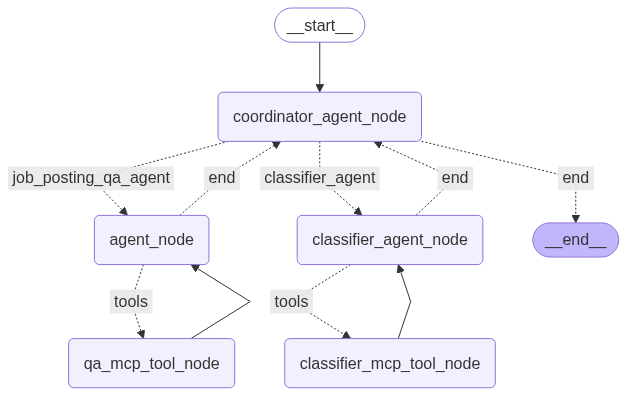

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [116]:
qa_tool_descriptions

[{'name': 'get_formatted_context',
  'description': 'Get the top k context, each representing an job posting for a given query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the top k context for'},
    'top_k': {'default': 5,
     'title': 'Top K',
     'type': 'integer',
     'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
  'required': ['query'],
  'returns': {'type': 'str',
   'description': 'A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.'},
  'server': 'http://localhost:8001/mcp'},
 {'name': 'get_formatted_entities',
  'description': 'Get the top k context, each representing an job posting for a given query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the top k context for

In [21]:
classifier_tool_descriptions

[{'name': 'get_formatted_context',
  'description': 'Get the top k context, each representing an job posting for a given query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the top k context for'},
    'top_k': {'default': 5,
     'title': 'Top K',
     'type': 'integer',
     'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
  'required': ['query'],
  'returns': {'type': 'str',
   'description': 'A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.'},
  'server': 'http://localhost:8001/mcp'},
 {'name': 'get_prediction',
  'description': 'Classifies if a given job posting is real or fake.\nUses the top result from get_formatted_context as input\nand return the classification result.',
  'parameters': {'type': 'object',
   'properties': {'text': {'title': 'Text',
     'type': 'string

In [98]:
initial_state = {
    "messages": [{"role": "user", "content": "What is the weather today?"}],
    "qa_available_tools": qa_tool_descriptions
}

# initial_state = {
#     "messages": [{"role": "user", "content": "Tell me job_id 10397 ."}],
#     "available_tools": tool_descriptions
# }
result = await graph.ainvoke(initial_state)


[DEBUG] Coordinator Agent State:  <bound method BaseModel.model_dump_json of State(messages=[{'role': 'user', 'content': 'What is the weather today?'}], answer='', iteration=0, classifier_iteration=0, coordinator_iteration=0, job_posting_qa_final_answer=False, classifier_final_answer=False, coordinator_final_answer=False, qa_available_tools=[{'name': 'get_formatted_context', 'description': 'Get the top k context, each representing an job posting for a given query.', 'parameters': {'type': 'object', 'properties': {'query': {'title': 'Query', 'type': 'string', 'description': 'The query to get the top k context for'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer', 'description': 'The number of context chunks to retrieve, works best with 5 or more'}}}, 'required': ['query'], 'returns': {'type': 'str', 'description': 'A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.'}, 'server': 'http://localhost:8001/mcp

In [99]:
result

{'messages': [{'role': 'user', 'content': 'What is the weather today?'},
  AIMessage(content="I'm sorry, but I can only assist with queries related to job postings and fraud analysis. I am unable to provide weather information.", additional_kwargs={}, response_metadata={})],
 'answer': "I'm sorry, but I can only assist with queries related to job postings and fraud analysis. I am unable to provide weather information.",
 'coordinator_iteration': 1,
 'coordinator_final_answer': True,
 'qa_available_tools': [{'name': 'get_formatted_context',
   'description': 'Get the top k context, each representing an job posting for a given query.',
   'parameters': {'type': 'object',
    'properties': {'query': {'title': 'Query',
      'type': 'string',
      'description': 'The query to get the top k context for'},
     'top_k': {'default': 5,
      'title': 'Top K',
      'type': 'integer',
      'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
   'required':

In [18]:
initial_state = {
    "messages": [{"role": "user", "content": "Tell me about job_id 10397."}],
    "qa_available_tools": qa_tool_descriptions 
}

# initial_state = {
#     "messages": [{"role": "user", "content": "Tell me job_id 10397 ."}],
#     "available_tools": tool_descriptions
# }
result = await graph.ainvoke(initial_state)


[DEBUG] Coordinator Agent State:  <bound method BaseModel.model_dump_json of State(messages=[{'role': 'user', 'content': 'Tell me about job_id 10397.'}], answer='', iteration=0, classifier_iteration=0, coordinator_iteration=0, job_posting_qa_final_answer=False, classifier_final_answer=False, coordinator_final_answer=False, qa_available_tools=[{'name': 'get_formatted_context', 'description': 'Get the top k context, each representing an job posting for a given query.', 'parameters': {'type': 'object', 'properties': {'query': {'title': 'Query', 'type': 'string', 'description': 'The query to get the top k context for'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer', 'description': 'The number of context chunks to retrieve, works best with 5 or more'}}}, 'required': ['query'], 'returns': {'type': 'str', 'description': 'A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.'}, 'server': 'http://localhost:8001/mc

In [19]:
result 

{'messages': [{'role': 'user', 'content': 'Tell me about job_id 10397.'},
  AIMessage(content='Retrieving job posting details for job_id 10397.', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'get_formatted_context', 'args': {'query': 'job_id 10397', 'top_k': 1}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='CallToolResult(content=[TextContent(type=\'text\', text="- 10397: Director of Software Engineering Company: #URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389f1bbaf2a1cb071e3f2b6e7e# and Aptitude Staffing Solutions have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model.\\xa0 Our focus is to help develop and achieve your career goals while makeing\\n    Job Id: 10397\\n    Description: As Director of Software Engineering\'s newly forming New York development team, you will be a “player-coach” who will contribute to and drive high-level architecture and planning, manage day-to-day issu

In [20]:
initial_state = {
    "messages": [{"role": "user", "content": "Tell me if job_id 10397 is real or fake. Use classification model if available"}],
    "classifier_available_tools": classifier_tool_descriptions 
}

# initial_state = {
#     "messages": [{"role": "user", "content": "Tell me job_id 10397 ."}],
#     "available_tools": tool_descriptions
# }
result = await graph.ainvoke(initial_state)


[DEBUG] Coordinator Agent State:  <bound method BaseModel.model_dump_json of State(messages=[{'role': 'user', 'content': 'Tell me if job_id 10397 is real or fake. Use classification model if available'}], answer='', iteration=0, classifier_iteration=0, coordinator_iteration=0, job_posting_qa_final_answer=False, classifier_final_answer=False, coordinator_final_answer=False, qa_available_tools=[], classifier_available_tools=[{'name': 'get_formatted_context', 'description': 'Get the top k context, each representing an job posting for a given query.', 'parameters': {'type': 'object', 'properties': {'query': {'title': 'Query', 'type': 'string', 'description': 'The query to get the top k context for'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer', 'description': 'The number of context chunks to retrieve, works best with 5 or more'}}}, 'required': ['query'], 'returns': {'type': 'str', 'description': 'A dictionary of the top k context chunks with IDs prepending each chunk, each 

In [21]:
result

{'messages': [{'role': 'user',
   'content': 'Tell me if job_id 10397 is real or fake. Use classification model if available'},
  AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'get_formatted_context', 'args': {'query': '10397', 'top_k': 1}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='CallToolResult(content=[TextContent(type=\'text\', text="- 10397: Director of Software Engineering Company: #URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389f1bbaf2a1cb071e3f2b6e7e# and Aptitude Staffing Solutions have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model.\\xa0 Our focus is to help develop and achieve your career goals while makeing\\n    Job Id: 10397\\n    Description: As Director of Software Engineering\'s newly forming New York development team, you will be a “player-coach” who will contribute to and drive high-level architecture and planning, manage day-to-day issue